# Predicting Prices for Houses in King County, WA

**Authors: Jesse Markowitz, Dillon Medd, Ronak Parekh**

## Overview

[overview text]

### Business problems/questions

Analysis and modeling through regression yield the following factors as predictive of house prices in King County:
 - Factor 1
 - Factor 2
 - Factor 3???

Together, these factors...

## Data Understanding

*Describe our data source, import libraries*

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from statsmodels.tools.eval_measures import mse
%matplotlib inline

In [2]:
raw_df = pd.read_csv('./data/kc_house_data.csv')
# Keep only the columns we need for analysis and feature engineering
houses_df = raw_df[['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'condition', 
                    'grade', 'yr_built', 'zipcode', 'lat', 'long', 'sqft_living15']]
houses_df.head()

,date,price,bedrooms,bathrooms,sqft_living,condition,grade,yr_built,zipcode,lat,long,sqft_living15
0,10/13/2014,221900.0,3,1.00,1180,3,7,1955,98178,47.5112,-122.257,1340
1,12/9/2014,538000.0,3,2.25,2570,3,7,1951,98125,47.7210,-122.319,1690
2,2/25/2015,180000.0,2,1.00,770,3,6,1933,98028,47.7379,-122.233,2720
3,12/9/2014,604000.0,4,3.00,1960,5,7,1965,98136,47.5208,-122.393,1360
4,2/18/2015,510000.0,3,2.00,1680,3,8,1987,98074,47.6168,-122.045,1800


### Visualizations

*Put all our amazing viz: histograms, correlation heatmaps, the works. Really knock their socks off with this stuff.*

Explain why we log transform the stuff we do (prices, sqft_living) and show before/after histograms to show how it makes the distributions more normal looking. Because no one like weird-looking distributions. Get outta here with that skew.

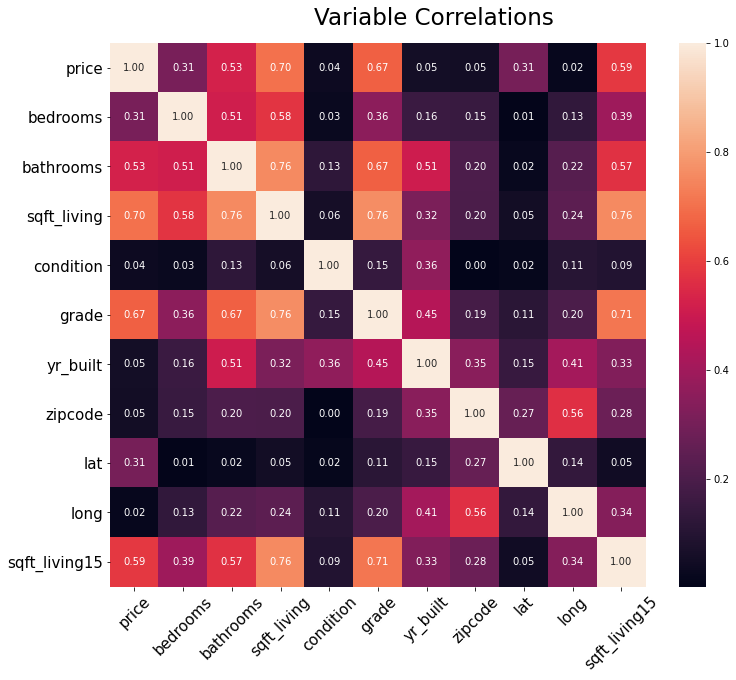

In [3]:
corr = houses_df.corr().abs()
fig, ax=plt.subplots(figsize=(12,10))
fig.suptitle('Variable Correlations', fontsize=23, y=.93)
h = sns.heatmap(corr, annot=True, fmt='.2f')
h.set_xticklabels(h.get_xmajorticklabels(), fontsize = 15, rotation=45)
h.set_yticklabels(h.get_ymajorticklabels(), fontsize = 15);

Normalizing skewed factors through log transformation: price, sqft_living

In [4]:
houses_df['log_price'] = np.log(houses_df['price'])
houses_df['log_sqft_living'] = np.log(houses_df['sqft_living'])

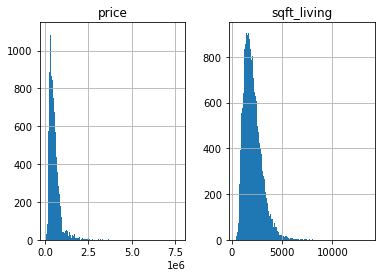

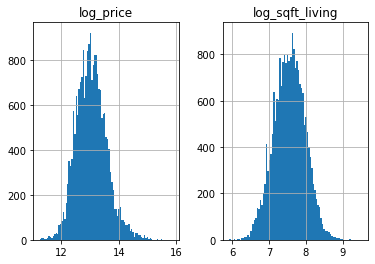

In [5]:
houses_df.hist(column=['price', 'sqft_living'], bins='auto')
houses_df.hist(column=['log_price', 'log_sqft_living'], bins='auto');

### Feature engineering

*Here's where we explain, show, and execute our creation of features such as:*
 - Distance bins!
 - ???

Haversine Distance function returns distance (in kilometers) when given two locations longitude and latitude. Source : https://towardsdatascience.com/heres-how-to-calculate-distance-between-2-geolocations-in-python-93ecab5bbba4

In [6]:
def haversine_distance(lat1, lon1, lat2, lon2):
   r = 6371
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   delta_phi = np.radians(lat2 - lat1)
   delta_lambda = np.radians(lon2 - lon1)
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
   res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
   return np.round(res, 2)

Distance From CC function returns a given location's distance from the center of seattle 

In [7]:
def distance_from_cc(lat, long):
    return haversine_distance(lat, long, 47.606, -122.332)

In [8]:
houses_df['distance_from_seattle'] = distance_from_cc(houses_df['lat'], houses_df['long'])
houses_df['sqft_divide_distance'] = houses_df['sqft_living'] / houses_df['distance_from_seattle']
houses_df['rooms'] = houses_df['bedrooms'] + houses_df['bathrooms']
houses_df['rooms_times_distance'] = houses_df['distance_from_seattle'] * houses_df['rooms']


In [9]:
city = houses_df[houses_df['distance_from_seattle'] <= 12]
suburb = houses_df[(houses_df['distance_from_seattle'] > 12) & (houses_df['distance_from_seattle'] <= 25)]
rural = houses_df[(houses_df['distance_from_seattle'] > 25)]

In [10]:
regression1 = LinearRegression()
regression2 = LinearRegression()
regression3 = LinearRegression()

sqft_1 = city['sqft_living'].values.reshape(-1, 1)
sqft_2 = suburb['sqft_living'].values.reshape(-1, 1)
sqft_3 = rural['sqft_living'].values.reshape(-1, 1)

regression1.fit(sqft_1, city['price'])
regression2.fit(sqft_2, suburb['price'])
regression3.fit(sqft_3, rural['price'])

pred_1 = regression1.predict(sqft_1)
pred_2 = regression2.predict(sqft_2)
pred_3 = regression3.predict(sqft_3)

print(regression1.coef_)
print(regression2.coef_)
print(regression3.coef_)

[408.12702571]
[255.37045837]
[192.9271941]


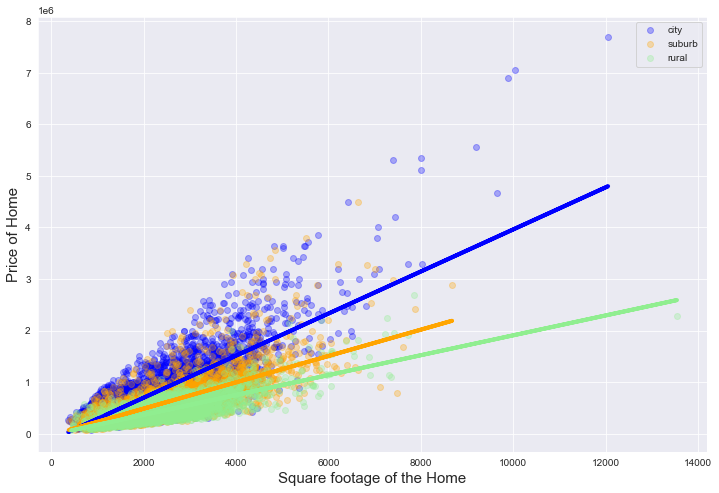

In [52]:
import seaborn as sns
fig = plt.figure(figsize = (12, 8))

sns.set_style('darkgrid')


plt.scatter(sqft_1, city['price'], color = 'b', alpha=0.3, label = 'City')
plt.scatter(sqft_2, suburb['price'], color = 'orange', alpha=0.3, label = 'Suburb')
plt.scatter(sqft_3, rural['price'], color = 'lightgreen', alpha=0.3, label = 'Rural')

plt.plot(sqft_1, pred_1, linewidth=4, color = 'b')
plt.plot(sqft_2, pred_2, linewidth=4, color = 'orange')
plt.plot(sqft_3, pred_3, linewidth=4, color = 'lightgreen')


plt.ylabel('Price of Home', fontsize = 15)
plt.xlabel('Square footage of the Home', fontsize = 15)
plt.legend();

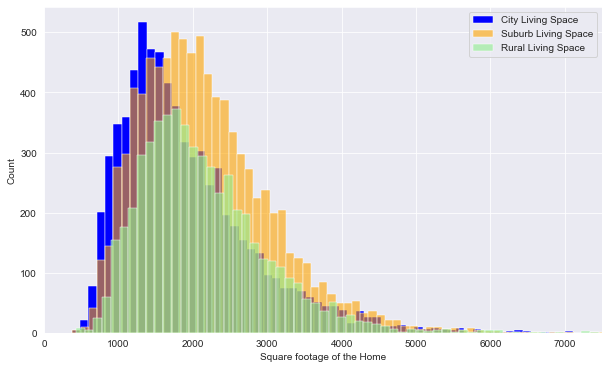

In [54]:
fig = plt.figure(figsize = (10, 6))



sns.histplot(data= city, x = 'sqft_living', color = 'b', label ='City Living Space', alpha = 1)
sns.histplot(data= suburb, x = 'sqft_living', color = 'orange', label ='Suburb Living Space', alpha = .6)
sns.histplot(data= rural, x = 'sqft_living', color = 'lightgreen', label='Rural Living Space', alpha = .6)

plt.legend()
plt.xlabel('Square footage of the Home')
plt.xlim(0, 7500);

(0.0, 2000000.0)

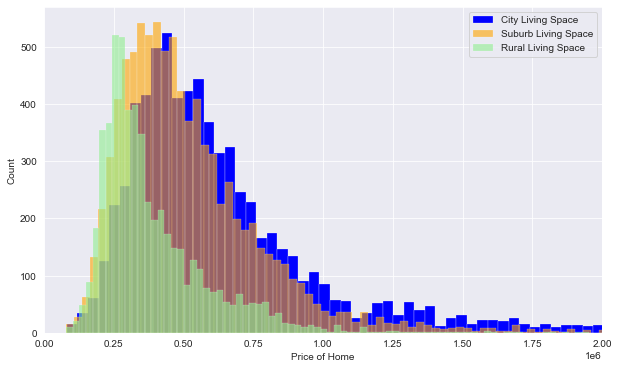

In [58]:
fig = plt.figure(figsize = (10, 6))



sns.histplot(data= city, x = 'price', color = 'b', label ='City Living Space', alpha = 1)
sns.histplot(data= suburb, x = 'price', color = 'orange', label ='Suburb Living Space', alpha = .6)
sns.histplot(data= rural, x = 'price', color = 'lightgreen', label='Rural Living Space', alpha = .6)

plt.legend()
plt.xlabel('Price of Home')
plt.xlim(0, 2000000)

## Modeling

*Show our modeling process and interpret the results!*

### Train/Test Split

In [12]:
y = houses_df.log_price
X = houses_df.drop(labels=['log_price'], axis=1)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 5)

In [14]:
houses_model_df = pd.concat([pd.DataFrame(y_train), X_train], axis=1).reset_index(drop=True)

In [15]:
houses_model_df

,log_price,date,price,bedrooms,bathrooms,sqft_living,condition,grade,yr_built,zipcode,lat,long,sqft_living15,log_sqft_living,distance_from_seattle,sqft_divide_distance,rooms,rooms_times_distance
0,12.911642,4/3/2015,405000.0,4,2.50,2620,3,9,1987,98058,47.4380,-122.152,2580,7.870930,23.06,113.616652,6.50,149.8900
1,13.356249,8/18/2014,631750.0,3,1.75,2360,5,7,1940,98117,47.6902,-122.382,1660,7.766417,10.08,234.126984,4.75,47.8800
2,13.022543,10/9/2014,452500.0,3,2.50,2240,3,7,2002,98065,47.5361,-121.880,2480,7.714231,34.79,64.386318,5.50,191.3450
3,15.356670,6/17/2014,4670000.0,5,6.75,9640,3,12,1983,98040,47.5570,-122.210,3270,9.173676,10.65,905.164319,11.75,125.1375
4,13.471611,2/24/2015,709000.0,3,2.75,2780,4,8,1913,98118,47.5632,-122.270,1700,7.930206,6.65,418.045113,5.75,38.2375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17272,12.570716,7/31/2014,288000.0,3,1.75,1660,3,7,1978,98045,47.4448,-121.770,1240,7.414573,45.85,36.205016,4.75,217.7875
17273,13.171154,3/13/2015,525000.0,3,2.50,2200,3,8,2000,98065,47.5319,-121.867,2400,7.696213,35.85,61.366806,5.50,197.1750
17274,12.577636,7/24/2014,290000.0,2,1.50,770,3,7,2006,98116,47.5644,-122.388,1350,6.646391,6.25,123.200000,3.50,21.8750
17275,13.049793,3/27/2015,465000.0,5,1.75,2000,3,7,1953,98178,47.5084,-122.246,2340,7.600902,12.63,158.353127,6.75,85.2525


### Baseline Model

*Explain: simplest model is 'price ~ sqft_living'*

In [16]:
baseline_model = sm.formula.ols(formula='log_price ~ log_sqft_living', data = houses_model_df).fit()

baseline_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                 1.426e+04
Date:                Thu, 26 Aug 2021   Prob (F-statistic):               0.00
Time:                        09:22:44   Log-Likelihood:                -8207.8
No. Observations:               17277   AIC:                         1.642e+04
Df Residuals:                   17275   BIC:                         1.644e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           6.7488      0.053    127.736      0.000       6.645       6.852
log_sqft_living     0.8344      0.007    119.422      0.000       0.821       0.848
==============================================================================
Omnibus:                       99.045   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               92.260
Skew:                           0.146   Prob(JB):                     9.25e-21
Kurtosis:                       2.793   Cond. No.                         137.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

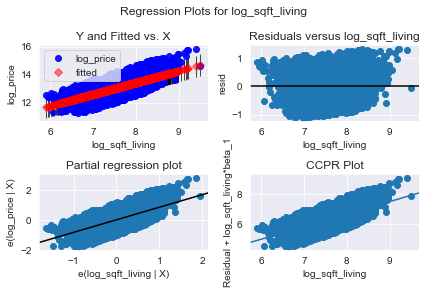

In [17]:
fig = sm.graphics.plot_regress_exog(baseline_model, "log_sqft_living")
fig.tight_layout(pad=1.0)

In [18]:
y_train_preds = baseline_model.predict(X_train)
y_test_preds = baseline_model.predict(X_test)
baseline_train_mse = mse(y_train_preds, y_train)
baseline_test_mse = mse(y_test_preds, y_test)

print('Baseline mse on training data: ', baseline_train_mse)
print('Baseline mse on testing data:  ', baseline_test_mse)

Baseline mse on training data:  0.1514145280654338
Baseline mse on testing data:   0.14936244222233772


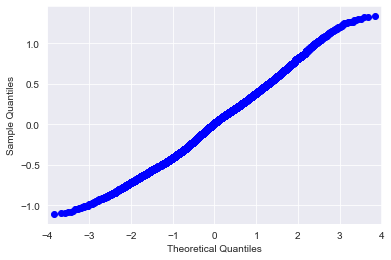

In [19]:
res = baseline_model.resid # residuals
fig = sm.qqplot(res)
plt.show()

### Model validation

In [20]:
final_model = sm.formula.ols(formula = 'log_price ~ log_sqft_living + sqft_divide_distance + grade + sqft_living15 + distance_from_seattle', data = houses_model_df).fit()

final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     9014.
Date:                Thu, 26 Aug 2021   Prob (F-statistic):               0.00
Time:                        09:22:47   Log-Likelihood:                -2318.9
No. Observations:               17277   AIC:                             4650.
Df Residuals:                   17271   BIC:                             4696.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 9.3101      0.053    174.070      0.000       9.205       9.415
log_sqft_living           0.3478      0.009     39.254      0.000       0.330       0.365
sqft_divide_distance      0.0004   1.81e-05     20.460      0.000       0.000       0.000
grade                     0.1328      0.003     45.249      0.000       0.127       0.139
sqft_living15             0.0002   4.98e-06     35.267      0.000       0.000       0.000
distance_from_seattle    -0.0171      0.000    -64.410      0.000      -0.018      -0.017
==============================================================================
Omnibus:                      183.545   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              314.889
Skew:                           0.020   Prob(JB):                     4.20e-69
Kurtosis:                       3.660   Cond. No.                     5.42e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.42e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [21]:
y_train_preds = final_model.predict(X_train)
y_test_preds = final_model.predict(X_test)
baseline_train_mse = mse(y_train_preds, y_train)
baseline_test_mse = mse(y_test_preds, y_test)

print('Baseline mse on training data: ', baseline_train_mse)
print('Baseline mse on testing data:  ', baseline_test_mse)

Baseline mse on training data:  0.0765781972426975
Baseline mse on testing data:   0.07597046311166614


*Use R^2, rmse, QQ plots, etc. to explain why our model is the bomb dot com.*

## Conclusions

Hit 'em with that knowledge, son!

**Next steps:**
 - Future 1
 - Future 2
 - Future 3